In [1]:
from scipy.sparse import csc_array as spcsc
from scipy import sparse
from scipy.sparse import kron as spkrn
from scipy.sparse.linalg import expm
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import random
import numpy as np
import os
import sys
from scipy.optimize import minimize, Bounds
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import qasm_simulator
from qiskit_aer import AerSimulator
import networkx as nx
from tqdm import tqdm
from numpy import pi
from qiskit.quantum_info import Operator

In [2]:
from scipy.sparse import csc_array as spcsc
from scipy import sparse
from scipy.sparse import kron as spkrn
from scipy.sparse.linalg import expm
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import random
import numpy as np
import os
import sys
from scipy.optimize import minimize, Bounds
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import qasm_simulator
from qiskit_aer import QasmSimulator
from qiskit_aer import AerSimulator
import networkx as nx
from tqdm import tqdm
from numpy import pi
from qiskit_aer import qasm_simulator
from qiskit_aer import AerSimulator

In [3]:
from itertools import combinations

def generate_xy_mixer_strings(n_qubits, ring=False):
    """
    Generate XY mixer Pauli strings for a chain or ring topology.

    Args:
        n_qubits (int): Number of qubits.
        ring (bool): If True, include ring connection (i.e., connect last to first).

    Returns:
        List[str]: List of Pauli strings (e.g., "iixx", "iiyy").
    """
    mixer_strings = []
    for i in range(n_qubits - 1):
        # Generate X_i X_{i+1}
        xx_str = ['I'] * n_qubits
        xx_str[i] = 'X'
        xx_str[i+1] = 'X'
        mixer_strings.append(''.join(xx_str))
        
        # Generate Y_i Y_{i+1}
        yy_str = ['I'] * n_qubits
        yy_str[i] = 'Y'
        yy_str[i+1] = 'Y'
        mixer_strings.append(''.join(yy_str))
    
    if ring and n_qubits > 2:
        # Add connection from last to first
        xx_str = ['I'] * n_qubits
        xx_str[-1] = 'X'
        xx_str[0] = 'X'
        mixer_strings.append(''.join(xx_str))

        yy_str = ['I'] * n_qubits
        yy_str[-1] = 'Y'
        yy_str[0] = 'Y'
        mixer_strings.append(''.join(yy_str))
    
    return mixer_strings
    
def generate_swap_mixer_strings(n_qubits, allowed_pairs=None):
    """
    Generate SWAP mixer Pauli strings (X_i X_j + Y_i Y_j) for allowed qubit pairs.

    Args:
        n_qubits (int): Number of qubits.
        allowed_pairs (List[Tuple[int, int]]): Optional list of qubit index pairs.
            If None, all unique pairs are used.

    Returns:
        List[str]: List of Pauli strings like "ixxii", "iyyii", etc.
    """
    mixer_strings = []
    if allowed_pairs is None:
        allowed_pairs = list(combinations(range(n_qubits), 2))  # All i < j pairs

    for i, j in allowed_pairs:
        xx_str = ['I'] * n_qubits
        yy_str = ['I'] * n_qubits
        xx_str[i] = xx_str[j] = 'X'
        yy_str[i] = yy_str[j] = 'Y'
        mixer_strings.append(''.join(xx_str))
        mixer_strings.append(''.join(yy_str))
    
    return mixer_strings

def generate_grover_diffusion_pauli_strings(n_qubits):
    """
    Approximate the Grover mixer (diffusion operator) in terms of Z-basis Pauli strings.
    Returns the Pauli strings for the diagonal reflection operator 2|0><0| - I.
    """
    pauli_strings = []
    for bits in product(['I', 'Z'], repeat=n_qubits):
        if all(b == 'I' for b in bits):
            continue  # skip the identity term
        pauli_strings.append(''.join(bits))
    return pauli_strings


def generate_zz_cost_strings(A):
    """
    Generate Pauli Z⊗Z strings from binary matrix A.
    For each row, create ZZ strings for each pair of 1s,
    with 'Z's placed at (n-i-1) and (n-j-1).

    Args:
        A (List[List[int]]): Binary matrix of shape (m, n)

    Returns:
        Set[str]: Set of unique Pauli strings like "iizzii"
    """
    cost_strings = set()
    n = len(A[0])

    for row in A:
        ones = [i for i, bit in enumerate(row) if bit == 1]
        for i, j in combinations(ones, 2):
            pauli = ['I'] * n
            pauli[n - i - 1] = 'Z'
            pauli[n - j - 1] = 'Z'
            cost_strings.add(''.join(pauli))

    return cost_strings

In [4]:
"""Implementation of Matrix-based QAOA using SamplingVQE."""

from __future__ import annotations

import numpy as np
from itertools import combinations

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE

def create_cost_operator(A: np.ndarray) -> SparsePauliOp:
    """Create the cost Hamiltonian for a given matrix A.
    
    The Hamiltonian represents x^T (A^T A) x
    
    Args:
        A: Binary matrix of shape (m, n)
        
    Returns:
        The cost Hamiltonian as a SparsePauliOp
    """
    num_qubits = A.shape[1]
    ATA = A.T @ A
    
    pauli_list = []
    coeffs = []
    
    # Add ZZ terms for each pair in ATA
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            if ATA[i,j] != 0:
                # Create ZZ term
                pauli_str = ['I'] * num_qubits
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append(Pauli("".join(pauli_str)))
                coeffs.append(float(ATA[i,j]))
    
    # Add diagonal terms
    for i in range(num_qubits):
        if ATA[i,i] != 0:
            pauli_str = ['I'] * num_qubits
            pauli_str[i] = 'Z'
            pauli_list.append(Pauli("".join(pauli_str)))
            coeffs.append(float(ATA[i,i]))
    
    return SparsePauliOp(pauli_list, coeffs)

def circuit_generator(pauli_string: str, q_no: int, parameter: Parameter) -> QuantumCircuit:
    """Generate a quantum circuit for a given Pauli string."""
    qc = QuantumCircuit(q_no)
    
    for i, pauli in enumerate(pauli_string):
        if pauli == 'X':
            qc.rx(parameter, i)
        elif pauli == 'Z':
            qc.rz(parameter, i)
    
    return qc

def get_string_lists(A: np.ndarray) -> tuple[list[str], list[str]]:
    """Get the X and Z string lists for the QAOA circuit.
    
    Args:
        A: Binary matrix of shape (m, n)
    
    Returns:
        Tuple of (mixer strings, cost strings)
    """
    num_qubits = A.shape[1]
    
    # Create X strings for mixer terms
    string_list_x = ['X' + 'I' * (i) + 'I' * (num_qubits - i - 1) 
                     for i in range(num_qubits)]
    
    # Create ZZ strings for cost terms using the provided function
    string_list_z = list(generate_zz_cost_strings(A.tolist()))
    
    return string_list_x, string_list_z

def create_qaoa_ansatz(A: np.ndarray, reps: int = 1) -> QuantumCircuit:
    """Creates a parameterized QAOA ansatz circuit using string decomposition.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        
    Returns:
        Parameterized QAOA circuit
    """
    num_qubits = A.shape[1]
    string_list_x, string_list_z = get_string_lists(A)
    
    # Create parameters for the circuit
    betas = [Parameter(f'β_{i}') for i in range(reps)]
    gammas = [Parameter(f'γ_{i}') for i in range(reps)]
    
    # Create initial circuit with Hadamards
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.h(i)
    
    # Build QAOA layers using string decomposition
    for p in range(reps):
        # Apply cost unitaries using Z strings
        for z_string in string_list_z:
            z_circuit = circuit_generator(z_string, num_qubits, 2 * gammas[p])
            qc = z_circuit.compose(qc)
        
        # Apply mixer unitaries using X strings
        for x_string in string_list_x:
            x_circuit = circuit_generator(x_string, num_qubits, 2 * betas[p])
            qc = x_circuit.compose(qc)
    
    qc.measure_all()
    # qc.draw("mpl")
    return qc

def maxcut_obj_set_spin(x: str | np.ndarray, A: np.ndarray) -> float:
    """Computes x^T (A^T A) x with x in {-1, +1} spin encoding."""
    if isinstance(x, str):
        x = np.array([1 if bit == '1' else -1 for bit in x])
    else:
        x = np.array([1 if bit == 1 else -1 for bit in x])

    ATA = A.T @ A
    obj = x.T @ ATA @ x
    return float(obj)

def format_bitstring(integer_value: int, num_qubits: int) -> str:
    """Convert an integer to a binary string of specified length."""
    return format(integer_value, f'0{num_qubits}b')

def solve_optimization(A: np.ndarray, reps: int = 1, shots: int = 1024) -> tuple[dict[str, float], float]:
    """Solves the optimization problem for a given matrix A using SamplingVQE."""
    # Create the cost Hamiltonian
    operator = create_cost_operator(A)
    
    # Create the parameterized ansatz circuit
    ansatz = create_qaoa_ansatz(A, reps)
    
    # Set up the SamplingVQE algorithm
    sampler = Sampler(options={"shots": shots})
    optimizer = COBYLA()
    
    # Initial point for optimization (all zeros)
    initial_point = np.zeros(2 * reps)
    
    vqe = SamplingVQE(sampler, ansatz, optimizer, initial_point=initial_point)
    
    # Run the algorithm
    result = vqe.compute_minimum_eigenvalue(operator)
    
    # Get the measurement counts and convert to proper format
    num_qubits = A.shape[1]
    counts = {format_bitstring(int(k), num_qubits): v 
             for k, v in result.eigenstate.items()}
    
    # Get the optimal value
    optimal_value = result.optimal_value
    
    return counts, optimal_value

def analyze_results(counts: dict[str, float], A: np.ndarray) -> tuple[str, float]:
    """Analyze the measurement results to find the best solution."""
    best_bitstring = None
    best_value = float('inf')
    
    for bitstring in counts:
        obj_value = maxcut_obj_set_spin(bitstring, A)
        if obj_value < best_value:
            best_value = obj_value
            best_bitstring = bitstring
            
    return best_bitstring, best_value

def main():
    """Example usage of the optimizer."""
    # Create a test matrix A
    A = np.array([
        [1, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 1, 1]
    ])
    
    # Solve optimization problem
    counts, optimal_value = solve_optimization(A, reps=1, shots=1024)
    
    print("=== Optimization Results ===")
    print(f"Matrix A:\n{A}")
    print(f"\nOptimal value: {optimal_value:.2f}")
    print("\nMeasurement counts:")
    
    # Format counts for better readability
    for bitstring, probability in counts.items():
        obj_value = maxcut_obj_set_spin(bitstring, A)
        count = int(probability * 1024)  # Convert probability to approximate count
        print(f"|{bitstring}⟩: {count} times (objective value = {obj_value:.2f})")
    
    # Analyze the results
    best_bitstring, best_value = analyze_results(counts, A)
    print(f"\nBest solution found: |{best_bitstring}⟩ with objective value {best_value:.2f}")

if __name__ == "__main__":
    main()

=== Optimization Results ===
Matrix A:
[[1 1 0 0]
 [0 1 1 0]
 [0 0 1 1]]

Optimal value: -0.94

Measurement counts:
|0000⟩: 6 times (objective value = 12.00)
|0001⟩: 126 times (objective value = 8.00)
|0010⟩: 9 times (objective value = 4.00)
|0011⟩: 104 times (objective value = 8.00)
|0100⟩: 5 times (objective value = 4.00)
|0101⟩: 126 times (objective value = 0.00)
|0110⟩: 9 times (objective value = 4.00)
|0111⟩: 131 times (objective value = 8.00)
|1000⟩: 5 times (objective value = 8.00)
|1001⟩: 114 times (objective value = 4.00)
|1010⟩: 2 times (objective value = 0.00)
|1011⟩: 116 times (objective value = 4.00)
|1100⟩: 5 times (objective value = 8.00)
|1101⟩: 131 times (objective value = 4.00)
|1110⟩: 9 times (objective value = 8.00)
|1111⟩: 126 times (objective value = 12.00)

Best solution found: |0101⟩ with objective value 0.00


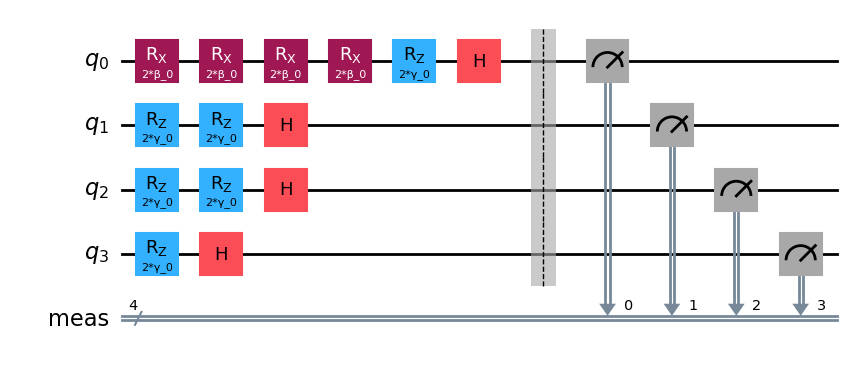

In [5]:
def create_qaoa_ansatz(A: np.ndarray, reps: int = 1) -> QuantumCircuit:
    """Creates a parameterized QAOA ansatz circuit using string decomposition.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        
    Returns:
        Parameterized QAOA circuit
    """
    num_qubits = A.shape[1]
    string_list_x, string_list_z = get_string_lists(A)
    
    # Create parameters for the circuit
    betas = [Parameter(f'β_{i}') for i in range(reps)]
    gammas = [Parameter(f'γ_{i}') for i in range(reps)]
    
    # Create initial circuit with Hadamards
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.h(i)
    
    # Build QAOA layers using string decomposition
    for p in range(reps):
        # Apply cost unitaries using Z strings
        for z_string in string_list_z:
            z_circuit = circuit_generator(z_string, num_qubits, 2 * gammas[p])
            qc = z_circuit.compose(qc)
        
        # Apply mixer unitaries using X strings
        for x_string in string_list_x:
            x_circuit = circuit_generator(x_string, num_qubits, 2 * betas[p])
            qc = x_circuit.compose(qc)
    
    qc.measure_all()
    return qc

A = np.array([
        [1, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 1, 1]
    ])

qc = create_qaoa_ansatz(A)
qc.draw("mpl")

In [6]:
n = 12
A = np.random.randint(0, 2, size=(n, n))

In [7]:
import numpy as np
from itertools import product
import time
import matplotlib.pyplot as plt

def brute_force_set_balancing(A):
    n = A.shape[1]
    min_val = float('inf')
    best_b_list = []

    for b_tuple in product([-1, 1], repeat=n):
        b = np.array(b_tuple)
        objective_val = np.linalg.norm(A @ b) ** 2

        if objective_val < min_val:
            min_val = objective_val
            best_b_list = [b.copy()]
        elif objective_val == min_val:
            best_b_list.append(b.copy())

    return min_val, best_b_list

brute_force_set_balancing(A)

(9.0,
 [array([-1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1]),
  array([-1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1]),
  array([-1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1]),
  array([-1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1]),
  array([-1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1]),
  array([ 1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1]),
  array([ 1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1]),
  array([ 1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1]),
  array([ 1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1]),
  array([ 1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1])])

In [8]:
from __future__ import annotations

import numpy as np
from itertools import combinations

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE

def create_cost_operator(A: np.ndarray) -> SparsePauliOp:
    """Create the cost Hamiltonian for a given matrix A.
    
    The Hamiltonian represents x^T (A^T A) x
    
    Args:
        A: Binary matrix of shape (m, n)
        
    Returns:
        The cost Hamiltonian as a SparsePauliOp
    """
    num_qubits = A.shape[1]
    ATA = A.T @ A
    
    pauli_list = []
    coeffs = []
    
    # Add ZZ terms for each pair in ATA
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            if ATA[i,j] != 0:
                # Create ZZ term
                pauli_str = ['I'] * num_qubits
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append(Pauli("".join(pauli_str)))
                coeffs.append(float(ATA[i,j]))
    
    # Add diagonal terms
    for i in range(num_qubits):
        if ATA[i,i] != 0:
            pauli_str = ['I'] * num_qubits
            pauli_str[i] = 'Z'
            pauli_list.append(Pauli("".join(pauli_str)))
            coeffs.append(float(ATA[i,i]))
    
    return SparsePauliOp(pauli_list, coeffs)

def get_string_lists(A: np.ndarray, mixer_type: str = 'X', ring: bool = False, allowed_pairs: list[tuple[int, int]] | None = None) -> tuple[list[str], list[str]]:
    """Get the mixer and cost string lists for the QAOA circuit.
    
    Args:
        A: Binary matrix of shape (m, n)
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
    
    Returns:
        Tuple of (mixer strings, cost strings)
    """
    num_qubits = A.shape[1]
    
    # Get mixer strings based on selected type
    if mixer_type == 'X':
        # Standard X mixer
        string_list_x = ['X' + 'I' * (i) + 'I' * (num_qubits - i - 1) 
                        for i in range(num_qubits)]
    elif mixer_type == 'XY':
        # XY mixer
        string_list_x = generate_xy_mixer_strings(num_qubits, ring=ring)
    elif mixer_type == 'SWAP':
        # SWAP mixer
        string_list_x = generate_swap_mixer_strings(num_qubits, allowed_pairs)
    elif mixer_type == 'GROVER':
        # Grover mixer
        string_list_x = generate_grover_diffusion_pauli_strings(num_qubits)
    else:
        raise ValueError(f"Unknown mixer type: {mixer_type}")
    
    # Create ZZ strings for cost terms
    string_list_z = list(generate_zz_cost_strings(A.tolist()))
    
    return string_list_x, string_list_z

def circuit_generator(pauli_string: str, q_no: int, parameter: Parameter) -> QuantumCircuit:
    """Generate a quantum circuit for a given Pauli string using the decomposition method.
    
    Args:
        pauli_string: String of Pauli operators ('I', 'X', 'Y', 'Z')
        q_no: Number of qubits
        parameter: Rotation angle parameter
        
    Returns:
        QuantumCircuit implementing the Pauli rotation
    """
    def assign_x_i(s: str) -> str:
        """Convert Pauli string to binary string marking non-identity positions."""
        return ''.join('1' if char in ['X', 'Y', 'Z'] else '0' for char in s)
    
    def get_cnot_positions(input_str: str, q_no: int) -> list[int]:
        """Get the CNOT gate positions for the circuit."""
        # Convert to binary and get integer value
        binary_int = assign_x_i(input_str)
        b = int(binary_int, 2)
        
        # Calculate new string based on parity
        new_string = b // 2 if b % 2 == 0 else (b - 1) // 2
        binary_new_string = format(new_string, 'b')
        
        # Get positions for CNOTs
        positions = [q_no - i - 1 for i, bit in enumerate(reversed(binary_new_string)) 
                    if bit == '1']
        
        # Convert to qiskit ordering
        return [q_no - i for i in positions]
    
    # Create the quantum circuit
    qc = QuantumCircuit(q_no)
    
    # Apply initial Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    
    # Get CNOT positions
    cnot_positions = get_cnot_positions(pauli_string, q_no)
    
    # Special cases check
    is_simple = (pauli_string[:-1] == 'I' * (len(pauli_string) - 1) and 
                pauli_string[-1] in ['X', 'Z'])
    
    if not is_simple:
        # Apply CNOT block based on parity
        b_val = int(assign_x_i(pauli_string), 2)
        
        if b_val % 2 == 0:  # Even case
            if cnot_positions:  # Check if there are any CNOT positions
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply rotation
    qc.rx(-parameter, 0)
    
    # Repeat CNOT block
    if not is_simple:
        if b_val % 2 == 0:  # Even case
            if cnot_positions:
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply final Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    
    return qc

def create_qaoa_ansatz(A: np.ndarray, reps: int = 1, mixer_type: str = 'X', 
                      ring: bool = False, allowed_pairs: list[tuple[int, int]] | None = None) -> QuantumCircuit:
    """Creates a parameterized QAOA ansatz circuit using string decomposition.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
        
    Returns:
        Parameterized QAOA circuit
    """
    num_qubits = A.shape[1]
    string_list_x, string_list_z = get_string_lists(A, mixer_type, ring, allowed_pairs)
    
    # Create parameters for the circuit
    betas = [Parameter(f'β_{i}') for i in range(reps)]
    gammas = [Parameter(f'γ_{i}') for i in range(reps)]
    
    # Create initial circuit with Hadamards
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.h(i)
    
    # Build QAOA layers using string decomposition
    for p in range(reps):
        # Apply cost unitaries using Z strings
        for z_string in string_list_z:
            z_circuit = circuit_generator(z_string, num_qubits, 2 * gammas[p])
            qc = z_circuit.compose(qc)
        
        # Apply mixer unitaries using selected mixer strings
        for x_string in string_list_x:
            x_circuit = circuit_generator(x_string, num_qubits, 2 * betas[p])
            qc = x_circuit.compose(qc)
    
    qc.measure_all()
    return qc

def solve_optimization(A: np.ndarray, reps: int = 1, shots: int = 1024,
                      mixer_type: str = 'X', ring: bool = False,
                      allowed_pairs: list[tuple[int, int]] | None = None) -> tuple[dict[str, float], float]:
    """Solves the optimization problem for a given matrix A using SamplingVQE.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        shots: Number of measurement shots
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
    
    Returns:
        Tuple of (measurement counts, optimal value)
    """
    # Create the cost Hamiltonian
    operator = create_cost_operator(A)
    
    # Create the parameterized ansatz circuit
    ansatz = create_qaoa_ansatz(A, reps, mixer_type, ring, allowed_pairs)
    
    # Set up the SamplingVQE algorithm
    sampler = Sampler(options={"shots": shots})
    optimizer = COBYLA()
    
    # Initial point for optimization (all zeros)
    initial_point = np.zeros(2 * reps)
    
    vqe = SamplingVQE(sampler, ansatz, optimizer, initial_point=initial_point)
    
    # Run the algorithm
    result = vqe.compute_minimum_eigenvalue(operator)
    
    # Get the measurement counts and convert to proper format
    num_qubits = A.shape[1]
    counts = {format_bitstring(int(k), num_qubits): v 
             for k, v in result.eigenstate.items()}
    
    # Get the optimal value
    optimal_value = result.optimal_value
    
    return counts, optimal_value

def main():
    """Example usage of the optimizer with different mixers."""
    # Create a test matrix A
    "PUT A here bhosdu"
    # Test different mixer types
    mixer_types = ['X', 'XY', 'SWAP', 'GROVER']
    
    for mixer_type in mixer_types:
        print(f"\n=== Testing {mixer_type} Mixer ===")
        
        # Additional parameters for specific mixers
        ring = False if mixer_type != 'XY' else True
        allowed_pairs = [(0,1), (1,2), (2,3)] if mixer_type == 'SWAP' else None
        
        # Solve optimization problem
        counts, optimal_value = solve_optimization(
            A, reps=1, shots=1024,
            mixer_type=mixer_type,
            ring=ring,
            allowed_pairs=allowed_pairs
        )
        
        print(f"Optimal value: {optimal_value:.2f}")
        print("\nMeasurement counts:")
        
        # Format counts for better readability
        for bitstring, probability in counts.items():
            obj_value = maxcut_obj_set_spin(bitstring, A)
            count = int(probability * 1024)
            print(f"|{bitstring}⟩: {count} times (objective value = {obj_value:.2f})")
        
        # Analyze the results
        best_bitstring, best_value = analyze_results(counts, A)
        print(f"\nBest solution found: |{best_bitstring}⟩ with objective value {best_value:.2f}")

if __name__ == "__main__":
    main()


=== Testing X Mixer ===
Optimal value: -0.98

Measurement counts:
|000000000001⟩: 1 times (objective value = 293.00)
|000000000111⟩: 1 times (objective value = 221.00)
|000000010000⟩: 1 times (objective value = 285.00)
|000000011001⟩: 1 times (objective value = 117.00)
|000000011101⟩: 1 times (objective value = 97.00)
|000000100001⟩: 1 times (objective value = 165.00)
|000000100101⟩: 1 times (objective value = 129.00)
|000000110011⟩: 1 times (objective value = 81.00)
|000000111010⟩: 1 times (objective value = 89.00)
|000001000010⟩: 1 times (objective value = 245.00)
|000001000101⟩: 1 times (objective value = 117.00)
|000001000111⟩: 1 times (objective value = 105.00)
|000001001011⟩: 1 times (objective value = 85.00)
|000001001101⟩: 1 times (objective value = 69.00)
|000001001111⟩: 1 times (objective value = 57.00)
|000001010110⟩: 1 times (objective value = 97.00)
|000001011111⟩: 1 times (objective value = 25.00)
|000001100000⟩: 1 times (objective value = 161.00)
|000001101001⟩: 1 times

KeyboardInterrupt: 

In [10]:
import numpy as np
from itertools import product
import time
import matplotlib.pyplot as plt
import tqdm as tqdm
from __future__ import annotations

import numpy as np
from itertools import product, combinations
from typing import List, Tuple, Dict, Any
from tqdm import tqdm

def maxcut_obj_set_spin(x: str | np.ndarray, A: np.ndarray) -> float:
    """Computes x^T (A^T A) x with x in {-1, +1} spin encoding."""
    if isinstance(x, str):
        x = np.array([1 if bit == '1' else -1 for bit in x])
    else:
        x = np.array([1 if bit == 1 else -1 for bit in x])

    ATA = A.T @ A
    obj = x.T @ ATA @ x
    return float(obj)

def analyze_results(counts: dict[str, float], A: np.ndarray) -> tuple[str, float]:
    """Analyze the measurement results to find the best solution."""
    best_bitstring = None
    best_value = float('inf')
    
    for bitstring, _ in counts.items():
        obj_value = maxcut_obj_set_spin(bitstring, A)
        if obj_value < best_value:
            best_value = obj_value
            best_bitstring = bitstring
            
    return best_bitstring, best_value

def brute_force_set_balancing(A: np.ndarray) -> float:
    """Compute optimal solution using brute force."""
    n = A.shape[1]
    min_val = float('inf')
    
    for b_tuple in product([-1, 1], repeat=n):
        b = np.array(b_tuple)
        objective_val = np.linalg.norm(A @ b) ** 2
        min_val = min(min_val, objective_val)
    
    return min_val

def main():
    """Run benchmarking of different mixers using SamplingVQE."""
    mixer_names = {
        'X': "X-mixer",
        'XY': "XY-mixer",
        'SWAP': "SWAP mixer",
        'GROVER': "Grover mixer"
    }
    mixer_types = ['X', 'XY', 'SWAP', 'GROVER']

    
    n_values = list(range(10, 11))
    num_trials = 10
    reps = 1
    shots = 1024
    
    for n in n_values:
        total_brute = 0.0
        qaoa_totals = {mixer: 0.0 for mixer in mixer_names}
        qaoa_ratios = {mixer: 0.0 for mixer in mixer_names}
        
        for trial in tqdm(range(num_trials), desc=f"Running trials for n={n}"):
            # Generate random problem instance
            A = np.random.randint(0, 2, size=(n, n))
            
            # Get brute force solution
            brute_val = brute_force_set_balancing(A)
            total_brute += brute_val
            
            # Try each mixer type
            for mixer_type in mixer_names:
                # Set mixer-specific parameters
                ring = mixer_type == 'XY'
                allowed_pairs = [(i, i+1) for i in range(n-1)] if mixer_type == 'SWAP' else None
                
                # Run QAOA with SamplingVQE
                counts, optimal_value = solve_optimization(
                    A, 
                    reps=reps,
                    shots=shots,
                    mixer_type=mixer_type,
                    ring=ring,
                    allowed_pairs=allowed_pairs
                )
                
                # Get best solution from measurements
                _, best_value = analyze_results(counts, A)
                
                qaoa_totals[mixer_type] += best_value
                qaoa_ratios[mixer_type] += brute_val / best_value
        
        # Print results for this problem size
        print(f"\n{'='*40}")
        print(f"n = {n}")
        print(f"Average Brute Force Objective: {total_brute / num_trials:.4f}")
        
        for mixer_type, name in mixer_names.items():
            avg_obj = qaoa_totals[mixer_type] / num_trials
            avg_ratio = qaoa_ratios[mixer_type] / num_trials
            print(f"\n{name}:")
            print(f"  Average Objective: {avg_obj:.4f}")
            print(f"  Average Approximation Ratio: {avg_ratio:.4f}")
        
        print(f"{'='*40}")

if __name__ == "__main__":

    main()

Running trials for n=5: 100%|███████████████████| 10/10 [00:08<00:00,  1.17it/s]



n = 5
Average Brute Force Objective: 2.6000

X-mixer:
  Average Objective: 2.6000
  Average Approximation Ratio: 1.0000

XY-mixer:
  Average Objective: 2.6000
  Average Approximation Ratio: 1.0000

SWAP mixer:
  Average Objective: 2.6000
  Average Approximation Ratio: 1.0000

Grover mixer:
  Average Objective: 2.6000
  Average Approximation Ratio: 1.0000


Running trials for n=6: 100%|███████████████████| 10/10 [00:16<00:00,  1.67s/it]



n = 6
Average Brute Force Objective: 3.7000

X-mixer:
  Average Objective: 3.7000
  Average Approximation Ratio: 1.0000

XY-mixer:
  Average Objective: 3.7000
  Average Approximation Ratio: 1.0000

SWAP mixer:
  Average Objective: 3.7000
  Average Approximation Ratio: 1.0000

Grover mixer:
  Average Objective: 3.7000
  Average Approximation Ratio: 1.0000


Running trials for n=7: 100%|███████████████████| 10/10 [00:30<00:00,  3.09s/it]



n = 7
Average Brute Force Objective: 4.4000

X-mixer:
  Average Objective: 4.4000
  Average Approximation Ratio: 1.0000

XY-mixer:
  Average Objective: 4.4000
  Average Approximation Ratio: 1.0000

SWAP mixer:
  Average Objective: 4.4000
  Average Approximation Ratio: 1.0000

Grover mixer:
  Average Objective: 4.4000
  Average Approximation Ratio: 1.0000


Running trials for n=8: 100%|███████████████████| 10/10 [01:07<00:00,  6.72s/it]



n = 8
Average Brute Force Objective: 4.0000

X-mixer:
  Average Objective: 4.0000
  Average Approximation Ratio: 1.0000

XY-mixer:
  Average Objective: 4.0000
  Average Approximation Ratio: 1.0000

SWAP mixer:
  Average Objective: 4.0000
  Average Approximation Ratio: 1.0000

Grover mixer:
  Average Objective: 4.0000
  Average Approximation Ratio: 1.0000


Running trials for n=9: 100%|███████████████████| 10/10 [02:33<00:00, 15.39s/it]


n = 9
Average Brute Force Objective: 4.2000

X-mixer:
  Average Objective: 4.2000
  Average Approximation Ratio: 1.0000

XY-mixer:
  Average Objective: 5.4000
  Average Approximation Ratio: 0.8413

SWAP mixer:
  Average Objective: 4.2000
  Average Approximation Ratio: 1.0000

Grover mixer:
  Average Objective: 4.2000
  Average Approximation Ratio: 1.0000


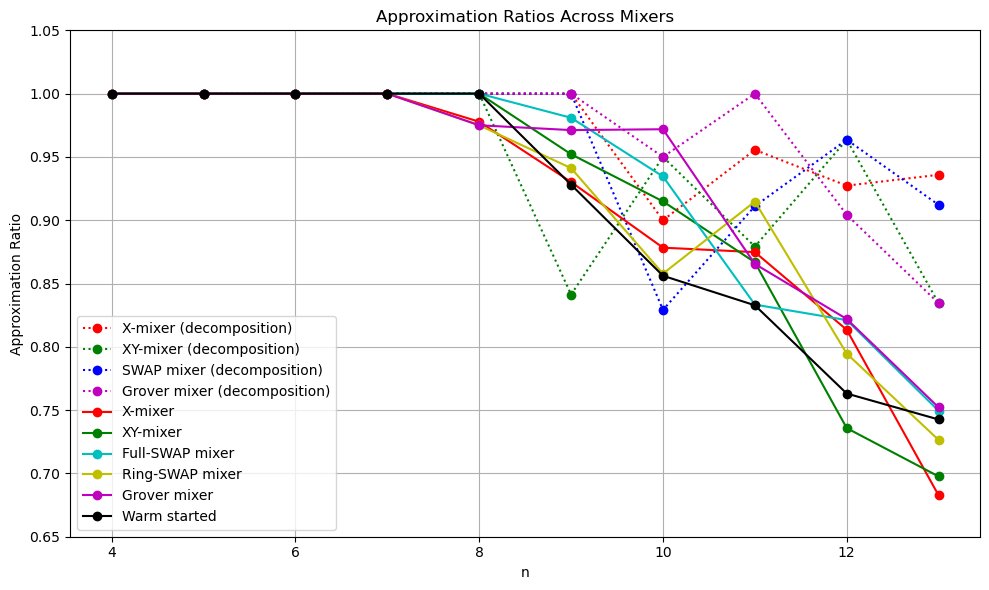

In [12]:
import matplotlib.pyplot as plt

# x values
n_short = [5, 6, 7, 8, 9, 10, 11, 12, 13]
n_long = list(range(4, 14))  # n = 4 to 13

# Short (dotted) data
x_ratio_1 = [1, 1, 1, 1, 1, 0.9, 0.9556, 0.9273, 0.9359]
xy_ratio_1 = [1, 1, 1, 1, 0.8413,  0.95, 0.8792, 0.9636, 0.8344]
swap_ratio_1 = [1, 1, 1, 1, 1, 0.8292, 0.9111, 0.9636, 0.9121]
grover_ratio_1 = [1, 1, 1, 1, 1, 0.95, 1.0, 0.9043, 0.8344]

# Long (solid) data
x_ratio_2 = [1.0, 1.0, 1.0, 1.0, 0.9778, 0.9301907142857143, 0.8783333333333334, 0.8748, 0.8134343434343435, 0.6826]
xy_ratio_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9521333333333333, 0.9148708994715661, 0.8667676767676769, 0.7357805081519788, 0.6976]
full_swap_ratio = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9809333333333334, 0.9345477878787879, 0.8333666868686869, 0.8211019788359788, 0.7494]
ring_swap_ratio = [1.0, 1.0, 1.0, 1.0, 0.975, 0.9411438092857144, 0.8578180206830207, 0.9147333333333334, 0.7946168518518518, 0.7264]
grover_ratio_2 = [1.0, 1.0, 1.0, 1.0, 0.975, 0.9712, 0.9718666666666667, 0.8654679774679776, 0.8219626510091217, 0.7521]
warm_start_ratio = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9280668994715662, 0.8561470206830207, 0.8328140740740742, 0.7630980708157375, 0.7426]

# Plotting
plt.figure(figsize=(10, 6))

# Dotted (short) lines
plt.plot(n_short, x_ratio_1, 'r:o', label='X-mixer (decomposition)')
plt.plot(n_short, xy_ratio_1, 'g:o', label='XY-mixer (decomposition)')
plt.plot(n_short, swap_ratio_1, 'b:o', label='SWAP mixer (decomposition)')
plt.plot(n_short, grover_ratio_1, 'm:o', label='Grover mixer (decomposition)')

# Solid (long) lines
plt.plot(n_long, x_ratio_2, 'r-o', label='X-mixer')
plt.plot(n_long, xy_ratio_2, 'g-o', label='XY-mixer')
plt.plot(n_long, full_swap_ratio, 'c-o', label='Full-SWAP mixer')
plt.plot(n_long, ring_swap_ratio, 'y-o', label='Ring-SWAP mixer')
plt.plot(n_long, grover_ratio_2, 'm-o', label='Grover mixer')
plt.plot(n_long, warm_start_ratio, 'k-o', label='Warm started')

# Style
plt.title('Approximation Ratios Across Mixers')
plt.xlabel('n')
plt.ylabel('Approximation Ratio')
plt.ylim(0.65, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/Users/nikhilskowshik/Downloads/ok_1.png")

In [ ]:
def circuit_generator(pauli_string: str, q_no: int, parameter: Parameter) -> QuantumCircuit:
    """Generate a quantum circuit for a given Pauli string using the decomposition method.
    
    Args:
        pauli_string: String of Pauli operators ('I', 'X', 'Y', 'Z')
        q_no: Number of qubits
        parameter: Rotation angle parameter
        
    Returns:
        QuantumCircuit implementing the Pauli rotation
    """
    def assign_x_i(s: str) -> str:
        """Convert Pauli string to binary string marking non-identity positions."""
        return ''.join('1' if char in ['X', 'Y', 'Z'] else '0' for char in s)
    
    def get_cnot_positions(input_str: str, q_no: int) -> list[int]:
        """Get the CNOT gate positions for the circuit."""
        # Convert to binary and get integer value
        binary_int = assign_x_i(input_str)
        b = int(binary_int, 2)
        
        # Calculate new string based on parity
        new_string = b // 2 if b % 2 == 0 else (b - 1) // 2
        binary_new_string = format(new_string, 'b')
        
        # Get positions for CNOTs
        positions = [q_no - i - 1 for i, bit in enumerate(reversed(binary_new_string)) 
                    if bit == '1']
        
        # Convert to qiskit ordering
        return [q_no - i for i in positions]
    
    # Create the quantum circuit
    qc = QuantumCircuit(q_no)
    
    # Apply initial Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    
    # Get CNOT positions
    cnot_positions = get_cnot_positions(pauli_string, q_no)
    
    # Special cases check
    is_simple = (pauli_string[:-1] == 'I' * (len(pauli_string) - 1) and 
                pauli_string[-1] in ['X', 'Z'])
    
    if not is_simple:
        # Apply CNOT block based on parity
        b_val = int(assign_x_i(pauli_string), 2)
        
        if b_val % 2 == 0:  # Even case
            if cnot_positions:  # Check if there are any CNOT positions
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply rotation
    qc.rx(-parameter, 0)
    
    # Repeat CNOT block
    if not is_simple:
        if b_val % 2 == 0:  # Even case
            if cnot_positions:
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply final Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    qc.barrier()
    
    return qc


def create_qaoa_ansatz(A: np.ndarray, reps: int = 1, mixer_type: str = 'X', 
                      ring: bool = False, allowed_pairs: list[tuple[int, int]] | None = None) -> QuantumCircuit:
    """Creates a parameterized QAOA ansatz circuit using string decomposition.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
        
    Returns:
        Parameterized QAOA circuit
    """
    num_qubits = A.shape[1]
    string_list_x, string_list_z = get_string_lists(A)
    
    # Create parameters for the circuit
    betas = [Parameter(f'β_{i}') for i in range(reps)]
    gammas = [Parameter(f'γ_{i}') for i in range(reps)]
    
    # Create initial circuit with Hadamards
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.h(i)
    
    # Build QAOA layers using string decomposition
    for p in range(reps):
        # Apply cost unitaries using Z strings
        for z_string in string_list_z:
            z_circuit = circuit_generator(z_string, num_qubits, 2 * gammas[p])
            qc.barrier()

            qc = z_circuit.compose(qc)
        
        # Apply mixer unitaries using selected mixer strings
        for x_string in string_list_x:
            x_circuit = circuit_generator(x_string, num_qubits, 2 * betas[p])
            qc.barrier()
            qc = x_circuit.compose(qc)
            
    
    qc.measure_all()
    return qc

ansatz = create_qaoa_ansatz(A, 1, 'X', False, None)
ansatz.draw("latex")

In [9]:
from __future__ import annotations

import numpy as np
from itertools import product, combinations
from typing import List, Tuple, Dict, Any
from tqdm import tqdm

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE

def create_cost_operator(A: np.ndarray) -> SparsePauliOp:
    """Create the cost Hamiltonian for a given matrix A.
    
    The Hamiltonian represents x^T (A^T A) x
    
    Args:
        A: Binary matrix of shape (m, n)
        
    Returns:
        The cost Hamiltonian as a SparsePauliOp
    """
    num_qubits = A.shape[1]
    ATA = A.T @ A
    
    pauli_list = []
    coeffs = []
    
    # Add ZZ terms for each pair in ATA
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            if ATA[i,j] != 0:
                # Create ZZ term
                pauli_str = ['I'] * num_qubits
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append(Pauli("".join(pauli_str)))
                coeffs.append(float(ATA[i,j]))
    
    # Add diagonal terms
    for i in range(num_qubits):
        if ATA[i,i] != 0:
            pauli_str = ['I'] * num_qubits
            pauli_str[i] = 'Z'
            pauli_list.append(Pauli("".join(pauli_str)))
            coeffs.append(float(ATA[i,i]))
    
    return SparsePauliOp(pauli_list, coeffs)

def get_string_lists(A: np.ndarray, mixer_type: str = 'X', ring: bool = False, allowed_pairs: list[tuple[int, int]] | None = None) -> tuple[list[str], list[str]]:
    """Get the mixer and cost string lists for the QAOA circuit.
    
    Args:
        A: Binary matrix of shape (m, n)
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
    
    Returns:
        Tuple of (mixer strings, cost strings)
    """
    num_qubits = A.shape[1]
    
    # Get mixer strings based on selected type
    if mixer_type == 'X':
        # Standard X mixer
        string_list_x = ['X' + 'I' * (i) + 'I' * (num_qubits - i - 1) 
                        for i in range(num_qubits)]
    elif mixer_type == 'XY':
        # XY mixer
        string_list_x = generate_xy_mixer_strings(num_qubits, ring=ring)
    elif mixer_type == 'SWAP':
        # SWAP mixer
        string_list_x = generate_swap_mixer_strings(num_qubits, allowed_pairs)
    elif mixer_type == 'GROVER':
        # Grover mixer
        string_list_x = generate_grover_diffusion_pauli_strings(num_qubits)
    else:
        raise ValueError(f"Unknown mixer type: {mixer_type}")
    
    # Create ZZ strings for cost terms
    string_list_z = list(generate_zz_cost_strings(A.tolist()))
    
    return string_list_x, string_list_z

def circuit_generator(pauli_string: str, q_no: int, parameter: Parameter) -> QuantumCircuit:
    """Generate a quantum circuit for a given Pauli string using the decomposition method.
    
    Args:
        pauli_string: String of Pauli operators ('I', 'X', 'Y', 'Z')
        q_no: Number of qubits
        parameter: Rotation angle parameter
        
    Returns:
        QuantumCircuit implementing the Pauli rotation
    """
    def assign_x_i(s: str) -> str:
        """Convert Pauli string to binary string marking non-identity positions."""
        return ''.join('1' if char in ['X', 'Y', 'Z'] else '0' for char in s)
    
    def get_cnot_positions(input_str: str, q_no: int) -> list[int]:
        """Get the CNOT gate positions for the circuit."""
        # Convert to binary and get integer value
        binary_int = assign_x_i(input_str)
        b = int(binary_int, 2)
        
        # Calculate new string based on parity
        new_string = b // 2 if b % 2 == 0 else (b - 1) // 2
        binary_new_string = format(new_string, 'b')
        
        # Get positions for CNOTs
        positions = [q_no - i - 1 for i, bit in enumerate(reversed(binary_new_string)) 
                    if bit == '1']
        
        # Convert to qiskit ordering
        return [q_no - i for i in positions]
    
    # Create the quantum circuit
    qc = QuantumCircuit(q_no)
    
    # Apply initial Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    
    # Get CNOT positions
    cnot_positions = get_cnot_positions(pauli_string, q_no)
    
    # Special cases check
    is_simple = (pauli_string[:-1] == 'I' * (len(pauli_string) - 1) and 
                pauli_string[-1] in ['X', 'Z'])
    
    if not is_simple:
        # Apply CNOT block based on parity
        b_val = int(assign_x_i(pauli_string), 2)
        
        if b_val % 2 == 0:  # Even case
            if cnot_positions:  # Check if there are any CNOT positions
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply rotation
    qc.rx(-parameter, 0)
    
    # Repeat CNOT block
    if not is_simple:
        if b_val % 2 == 0:  # Even case
            if cnot_positions:
                max_pos = max(cnot_positions)
                qc.cx(max_pos, 0)
                for pos in cnot_positions:
                    qc.cx(0, pos)
                qc.cx(max_pos, 0)
        else:  # Odd case
            for pos in cnot_positions:
                qc.cx(0, pos)
    
    # Apply final Hadamard gates
    for i, pauli in enumerate(reversed(pauli_string)):
        if pauli == 'Z':
            qc.h(i)
    
    return qc

def create_qaoa_ansatz(A: np.ndarray, reps: int = 1, mixer_type: str = 'X', 
                      ring: bool = False, allowed_pairs: list[tuple[int, int]] | None = None) -> QuantumCircuit:
    """Creates a parameterized QAOA ansatz circuit using string decomposition.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
        
    Returns:
        Parameterized QAOA circuit
    """
    num_qubits = A.shape[1]
    string_list_x, string_list_z = get_string_lists(A, mixer_type, ring, allowed_pairs)
    
    # Create parameters for the circuit
    betas = [Parameter(f'β_{i}') for i in range(reps)]
    gammas = [Parameter(f'γ_{i}') for i in range(reps)]
    
    # Create initial circuit with Hadamards
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.h(i)
    
    # Build QAOA layers using string decomposition
    for p in range(reps):
        # Apply cost unitaries using Z strings
        for z_string in string_list_z:
            z_circuit = circuit_generator(z_string, num_qubits, 2 * gammas[p])
            qc = z_circuit.compose(qc)
        
        # Apply mixer unitaries using selected mixer strings
        for x_string in string_list_x:
            x_circuit = circuit_generator(x_string, num_qubits, 2 * betas[p])
            qc = x_circuit.compose(qc)
    
    qc.measure_all()
    return qc

def solve_optimization(A: np.ndarray, reps: int = 1, shots: int = 1024,
                      mixer_type: str = 'X', ring: bool = False,
                      allowed_pairs: list[tuple[int, int]] | None = None) -> tuple[dict[str, float], float]:
    """Solves the optimization problem for a given matrix A using SamplingVQE.
    
    Args:
        A: Binary matrix of shape (m, n)
        reps: Number of QAOA repetitions
        shots: Number of measurement shots
        mixer_type: Type of mixer to use ('X', 'XY', 'SWAP', or 'GROVER')
        ring: Whether to use ring topology for XY mixer
        allowed_pairs: Allowed pairs for SWAP mixer
    
    Returns:
        Tuple of (measurement counts, optimal value)
    """
    # Create the cost Hamiltonian
    operator = create_cost_operator(A)
    
    # Create the parameterized ansatz circuit
    ansatz = create_qaoa_ansatz(A, reps, mixer_type, ring, allowed_pairs)
    
    # Set up the SamplingVQE algorithm
    sampler = Sampler(options={"shots": shots})
    optimizer = COBYLA()
    
    # Initial point for optimization (all zeros)
    initial_point = np.zeros(2 * reps)
    
    vqe = SamplingVQE(sampler, ansatz, optimizer, initial_point=initial_point)
    
    # Run the algorithm
    result = vqe.compute_minimum_eigenvalue(operator)
    
    # Get the measurement counts and convert to proper format
    num_qubits = A.shape[1]
    counts = {format_bitstring(int(k), num_qubits): v 
             for k, v in result.eigenstate.items()}
    
    # Get the optimal value
    optimal_value = result.optimal_value
    
    return counts, optimal_value

def main():
    """Example usage of the optimizer with different mixers."""
    # Create a test matrix A
    "PUT A here bhosdu"
    # Test different mixer types
    mixer_types = ['X', 'XY', 'SWAP', 'GROVER']
    
    for mixer_type in mixer_types:
        print(f"\n=== Testing {mixer_type} Mixer ===")
        
        # Additional parameters for specific mixers
        ring = False if mixer_type != 'XY' else True
        allowed_pairs = [(0,1), (1,2), (2,3)] if mixer_type == 'SWAP' else None
        
        # Solve optimization problem
        counts, optimal_value = solve_optimization(
            A, reps=1, shots=1024,
            mixer_type=mixer_type,
            ring=ring,
            allowed_pairs=allowed_pairs
        )
        
        print(f"Optimal value: {optimal_value:.2f}")
        print("\nMeasurement counts:")
        
        # Format counts for better readability
        for bitstring, probability in counts.items():
            obj_value = maxcut_obj_set_spin(bitstring, A)
            count = int(probability * 1024)
            print(f"|{bitstring}⟩: {count} times (objective value = {obj_value:.2f})")
        
        # Analyze the results
        best_bitstring, best_value = analyze_results(counts, A)
        print(f"\nBest solution found: |{best_bitstring}⟩ with objective value {best_value:.2f}")

if __name__ == "__main__":
    main()


=== Testing X Mixer ===
Optimal value: -8.43

Measurement counts:
|000011010111⟩: 1 times (objective value = 37.00)
|001001101011⟩: 1 times (objective value = 45.00)
|001110110000⟩: 1 times (objective value = 57.00)
|011001000110⟩: 1 times (objective value = 57.00)
|011111111110⟩: 1 times (objective value = 169.00)
|100000000000⟩: 2 times (objective value = 273.00)
|100000000011⟩: 2 times (objective value = 109.00)
|100000000100⟩: 1 times (objective value = 153.00)
|100000000101⟩: 1 times (objective value = 81.00)
|100000001011⟩: 1 times (objective value = 69.00)
|100000001110⟩: 1 times (objective value = 53.00)
|100000001111⟩: 1 times (objective value = 37.00)
|100000010000⟩: 1 times (objective value = 193.00)
|100000010010⟩: 1 times (objective value = 133.00)
|100000010011⟩: 2 times (objective value = 77.00)
|100000010101⟩: 1 times (objective value = 57.00)
|100000010110⟩: 1 times (objective value = 85.00)
|100000010111⟩: 2 times (objective value = 61.00)
|100000011000⟩: 1 times (ob

In [17]:
print("ok")

ok


Problem sizes:   0%|                                      | 0/3 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 163, in benchmark_optimizers
    counts, quantum_value, history = solve_optimization_with_optimizer(
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 53, in solve_optimization_with_optimizer
    sampler = Sampler(
TypeError: Sampler.__init__() got an unexpected keyword argument 'options'
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 163, in benchmark_optimizers
    counts, quantum_value, history = solve_optimization_with_optimizer(
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 53, in solve_optimization_with_optimizer
    sampler = Sampler(
TypeError: Sampler.__init__() got an unexpected keyword argument 'options


Size 4, Trial 0, X, COBYLA
Error with COBYLA: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, X, POWELL
Error with POWELL: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, X, BOBYQA
Error with BOBYQA: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, X, NELDER_MEAD
Error with NELDER_MEAD: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, XY, COBYLA
Error with COBYLA: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, XY, POWELL
Error with POWELL: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, XY, BOBYQA
Error with BOBYQA: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 4, Trial 0, XY, NELDER_MEAD
Error with NELDER_MEAD

Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 163, in benchmark_optimizers
    counts, quantum_value, history = solve_optimization_with_optimizer(
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 53, in solve_optimization_with_optimizer
    sampler = Sampler(
TypeError: Sampler.__init__() got an unexpected keyword argument 'options'
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 163, in benchmark_optimizers
    counts, quantum_value, history = solve_optimization_with_optimizer(
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_42626/646756470.py", line 53, in solve_optimization_with_optimizer
    sampler = Sampler(
TypeError: Sampler.__init__() got an unexpected keyword argument 'options'
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28h

Error with POWELL: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 6, Trial 2, XY, BOBYQA
Error with BOBYQA: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError

Size 6, Trial 2, XY, NELDER_MEAD
Error with NELDER_MEAD: Sampler.__init__() got an unexpected keyword argument 'options'
Full error: TypeError


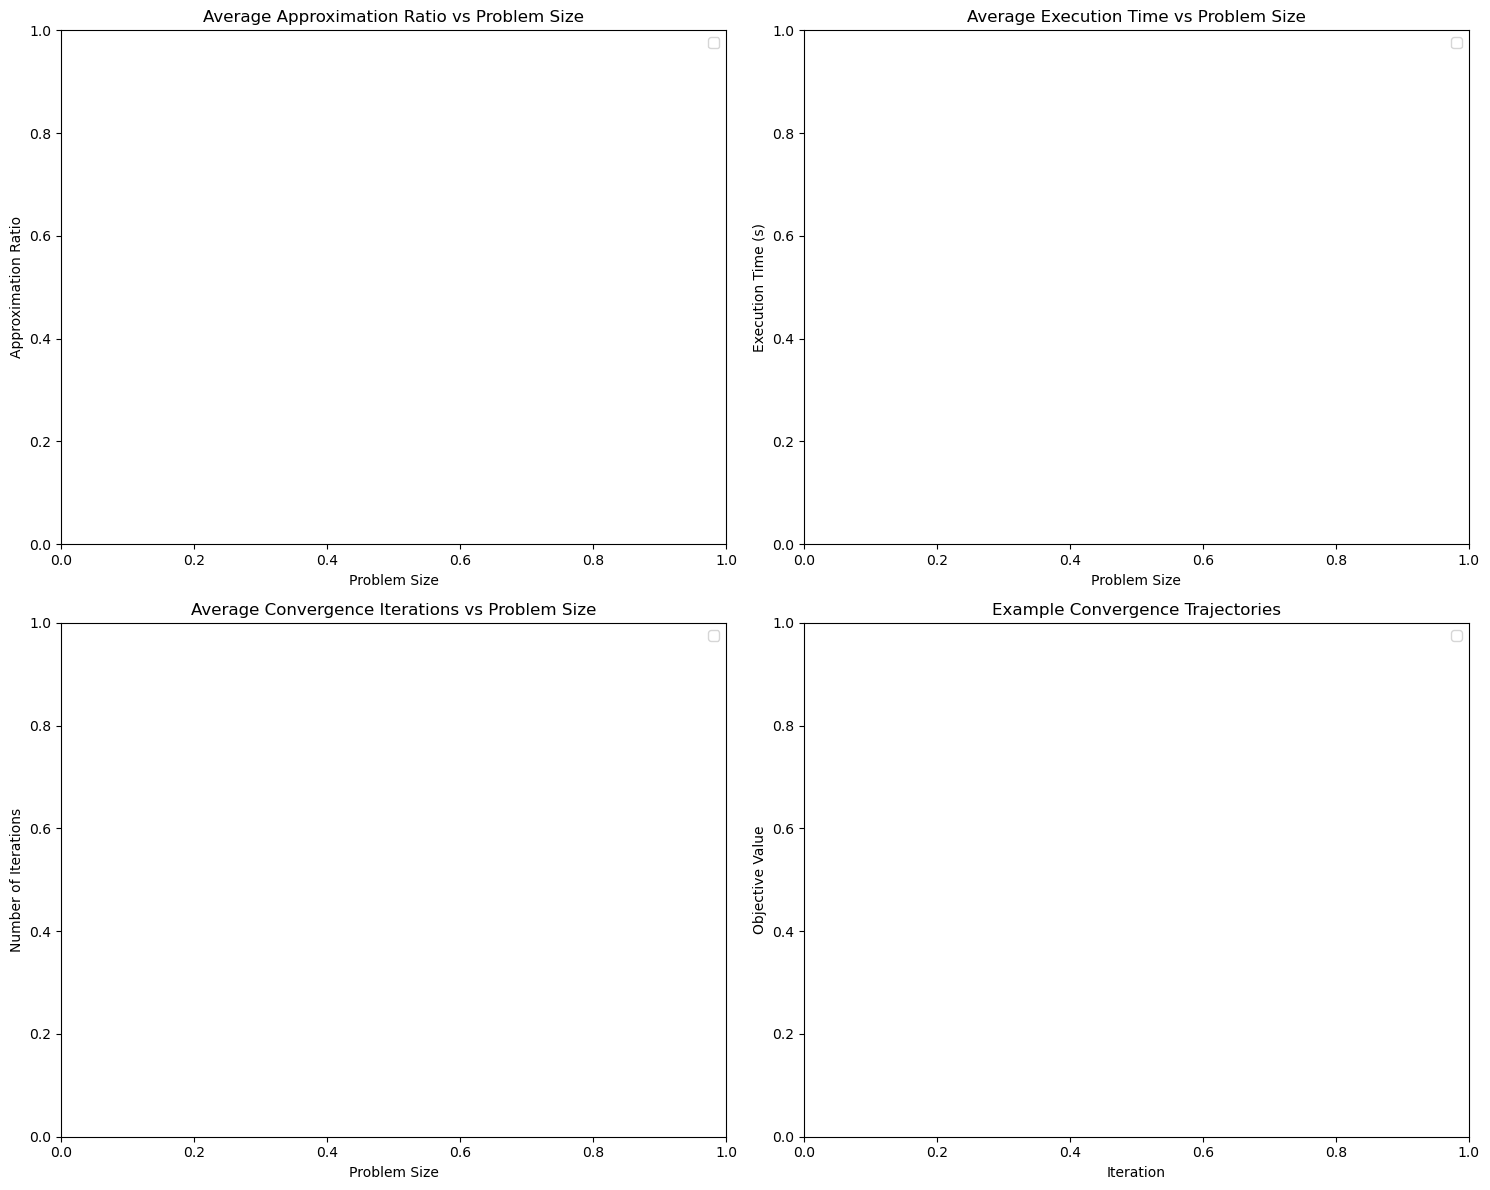

In [25]:
from __future__ import annotations

import numpy as np
from itertools import product, combinations
import time
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any
from tqdm import tqdm

# Import Qiskit packages
from qiskit_algorithms.optimizers import (
    COBYLA,
    POWELL,
    BOBYQA,
    NELDER_MEAD,
    SPSA,
    ADAM,
    AQGD
)
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

def solve_optimization_with_optimizer(
    A: np.ndarray,
    optimizer_name: str,
    reps: int = 1,
    shots: int = 1024,
    mixer_type: str = 'X',
    ring: bool = False,
    allowed_pairs: list[tuple[int, int]] | None = None,
    noise_level: str = 'none',
    **optimizer_kwargs
) -> tuple[dict[str, float], float, dict]:
    """
    Solves the optimization problem with specified optimizer.
    """
    # Create the cost Hamiltonian and ansatz
    operator = create_cost_operator(A)
    ansatz = create_qaoa_ansatz(A, reps, mixer_type, ring, allowed_pairs)
    
    # Set up backend and sampler
    if noise_level == 'none':
        backend = AerSimulator()
    else:
        noise_model = get_simple_noise_model(noise_level)
        backend = AerSimulator(
            noise_model=noise_model,
            basis_gates=['u1', 'u2', 'u3', 'cx']
        )
    
    # Create sampler with the backend
    sampler = Sampler(
        options={"shots": shots},
        backend_options={"noise_model": noise_model} if noise_level != 'none' else None
    )
    
    # Set up the optimizer
    optimizer = get_optimizer(optimizer_name, **optimizer_kwargs)
    
    # Create callback to track optimization history
    optimization_history = {
        'values': [],
        'parameters': [],
        'iterations': [],
        'time': []
    }
    
    start_time = time.time()
    
    def callback(eval_count, parameters, value, meta):
        optimization_history['values'].append(value)
        optimization_history['parameters'].append(parameters.copy())
        optimization_history['iterations'].append(eval_count)
        optimization_history['time'].append(time.time() - start_time)
    
    # Set up initial point
    initial_point = np.random.random(2 * reps) * 2 * np.pi
    
    vqe = SamplingVQE(
        sampler,
        ansatz,
        optimizer,
        initial_point=initial_point,
        callback=callback
    )
    
    # Run the algorithm
    result = vqe.compute_minimum_eigenvalue(operator)
    
    # Format the counts
    num_qubits = A.shape[1]
    counts = {format_bitstring(int(k), num_qubits): v 
             for k, v in result.eigenstate.items()}
    
    return counts, result.optimal_value, optimization_history

def get_simple_noise_model(noise_level: str = 'medium') -> NoiseModel:
    """
    Create a simple noise model.
    """
    noise_model = NoiseModel()
    
    # Configure noise parameters based on level
    if noise_level == 'low':
        p1q = 0.001
        p2q = 0.01
    elif noise_level == 'medium':
        p1q = 0.005
        p2q = 0.02
    else:  # high
        p1q = 0.01
        p2q = 0.05
    
    # Add depolarizing error
    error_1q = depolarizing_error(p1q, 1)
    error_2q = depolarizing_error(p2q, 2)
    
    # Add errors to noise model
    noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    return noise_model

def benchmark_optimizers(
    min_size: int = 4,
    max_size: int = 6,
    trials: int = 5,
    reps: int = 1,
    shots: int = 1024,
    mixer_types: list[str] = ['X', 'XY'],
    optimizers: list[str] = ['COBYLA', 'POWELL', 'BOBYQA', 'NELDER_MEAD'],
    plot_results: bool = True
) -> dict:
    """
    Benchmark different optimizers.
    """
    results = {
        'problem_sizes': [],
        'mixer_types': [],
        'optimizers': [],
        'approximation_ratios': [],
        'optimal_values': [],
        'execution_times': [],
        'convergence_iterations': [],
        'optimization_histories': []
    }
    
    for n in tqdm(range(min_size, max_size + 1), desc="Problem sizes"):
        for trial in range(trials):
            # Generate random problem instance
            A = np.random.randint(0, 2, size=(n, n))
            
            # Get classical optimal solution
            classical_optimal = brute_force_set_balancing(A)
            
            for mixer_type in mixer_types:
                for optimizer_name in optimizers:
                    print(f"\nSize {n}, Trial {trial}, {mixer_type}, {optimizer_name}")
                    
                    try:
                        # Run optimization
                        counts, quantum_value, history = solve_optimization_with_optimizer(
                            A,
                            optimizer_name,
                            reps=reps,
                            shots=shots,
                            mixer_type=mixer_type
                        )
                        
                        # Calculate metrics
                        approx_ratio = classical_optimal / quantum_value
                        exec_time = history['time'][-1]
                        iterations = len(history['iterations'])
                        
                        # Store results
                        results['problem_sizes'].append(n)
                        results['mixer_types'].append(mixer_type)
                        results['optimizers'].append(optimizer_name)
                        results['approximation_ratios'].append(approx_ratio)
                        results['optimal_values'].append(quantum_value)
                        results['execution_times'].append(exec_time)
                        results['convergence_iterations'].append(iterations)
                        results['optimization_histories'].append(history)
                        
                        print(f"Approximation ratio: {approx_ratio:.3f}")
                        print(f"Iterations: {iterations}")
                        print(f"Time: {exec_time:.2f}s")
                        
                    except Exception as e:
                        print(f"Error with {optimizer_name}: {str(e)}")
                        print(f"Full error: {e.__class__.__name__}")
                        import traceback
                        traceback.print_exc()
    
    if plot_results:
        plot_benchmark_results(results)
    
    return results

if __name__ == "__main__":
    # Import all necessary Qiskit packages
    from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
    from qiskit_aer.noise import depolarizing_error
    
    # Run benchmark with different optimizers
    results = benchmark_optimizers(
        min_size=4,
        max_size=6,
        trials=3,
        mixer_types=['X', 'XY'],
        optimizers=['COBYLA', 'POWELL', 'BOBYQA', 'NELDER_MEAD'],
        plot_results=True
    )

In [20]:
pip install scikit-quant

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 970.2 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-quant: filename=scikit_quant-0.8.2-py3-none-any.whl size=21496 sha256=6047ce6b6fe3df662eba81e21c14ab626bf8ccf7d589ac4236280ea074a1eb6f
  Stored in directory: /Users/nikhilskowshik/Library/Caches/pip/wheels/b2/8a/64/17c04cb672ab600acb7002fc3fda43ff98138e0ea063e1736b
  Created wheel for SQCommon: filename=sqcommon-0.3.2-py3-none-any.whl size=33

Problem sizes:   0%|                                      | 0/6 [00:00<?, ?it/s]


Size 5, Trial 0, X, COBYLA
Classical optimal: 3.000
Quantum value: -3.999
Approximation ratio: 0.750
Iterations: 30
Time: 0.15s

Size 5, Trial 0, X, POWELL
Classical optimal: 3.000
Quantum value: -4.000
Approximation ratio: 0.750
Iterations: 52
Time: 0.24s

Size 5, Trial 1, X, COBYLA
Classical optimal: 2.000
Quantum value: -3.000
Approximation ratio: 0.667
Iterations: 31
Time: 0.12s

Size 5, Trial 1, X, POWELL


Problem sizes:  17%|█████                         | 1/6 [00:00<00:03,  1.29it/s]

Classical optimal: 2.000
Quantum value: -3.000
Approximation ratio: 0.667
Iterations: 54
Time: 0.24s

Size 6, Trial 0, X, COBYLA
Classical optimal: 1.000
Quantum value: -1.000
Approximation ratio: 1.000
Iterations: 29
Time: 0.20s

Size 6, Trial 0, X, POWELL
Classical optimal: 1.000
Quantum value: -1.000
Approximation ratio: 1.000
Iterations: 96
Time: 0.60s

Size 6, Trial 1, X, COBYLA
Classical optimal: 4.000
Quantum value: -3.000
Approximation ratio: 1.333
Iterations: 30
Time: 0.17s

Size 6, Trial 1, X, POWELL


Problem sizes:  33%|██████████                    | 2/6 [00:02<00:04,  1.07s/it]

Classical optimal: 4.000
Quantum value: -3.000
Approximation ratio: 1.333
Iterations: 48
Time: 0.26s

Size 7, Trial 0, X, COBYLA
Classical optimal: 8.000
Quantum value: -4.000
Approximation ratio: 2.000
Iterations: 28
Time: 0.26s

Size 7, Trial 0, X, POWELL
Classical optimal: 8.000
Quantum value: -4.000
Approximation ratio: 2.000
Iterations: 54
Time: 0.48s

Size 7, Trial 1, X, COBYLA
Classical optimal: 4.000
Quantum value: -4.999
Approximation ratio: 0.800
Iterations: 23
Time: 0.20s

Size 7, Trial 1, X, POWELL


Problem sizes:  50%|███████████████               | 3/6 [00:03<00:04,  1.44s/it]

Classical optimal: 4.000
Quantum value: -5.000
Approximation ratio: 0.800
Iterations: 95
Time: 0.88s

Size 8, Trial 0, X, COBYLA
Classical optimal: 5.000
Quantum value: -4.000
Approximation ratio: 1.250
Iterations: 24
Time: 0.31s

Size 8, Trial 0, X, POWELL
Classical optimal: 5.000
Quantum value: -4.000
Approximation ratio: 1.250
Iterations: 94
Time: 1.22s

Size 8, Trial 1, X, COBYLA
Classical optimal: 7.000
Quantum value: -5.000
Approximation ratio: 1.400
Iterations: 24
Time: 0.32s

Size 8, Trial 1, X, POWELL


Problem sizes:  67%|████████████████████          | 4/6 [00:07<00:04,  2.19s/it]

Classical optimal: 7.000
Quantum value: -5.000
Approximation ratio: 1.400
Iterations: 103
Time: 1.39s

Size 9, Trial 0, X, COBYLA
Classical optimal: 3.000
Quantum value: -4.999
Approximation ratio: 0.600
Iterations: 24
Time: 0.45s

Size 9, Trial 0, X, POWELL
Classical optimal: 3.000
Quantum value: -5.000
Approximation ratio: 0.600
Iterations: 55
Time: 1.08s

Size 9, Trial 1, X, COBYLA
Classical optimal: 6.000
Quantum value: -5.999
Approximation ratio: 1.000
Iterations: 25
Time: 0.49s

Size 9, Trial 1, X, POWELL


Problem sizes:  83%|█████████████████████████     | 5/6 [00:11<00:02,  2.90s/it]

Classical optimal: 6.000
Quantum value: -6.000
Approximation ratio: 1.000
Iterations: 94
Time: 1.98s

Size 10, Trial 0, X, COBYLA
Classical optimal: 5.000
Quantum value: -2.999
Approximation ratio: 1.667
Iterations: 28
Time: 0.90s

Size 10, Trial 0, X, POWELL
Classical optimal: 5.000
Quantum value: -3.000
Approximation ratio: 1.667
Iterations: 70
Time: 2.06s

Size 10, Trial 1, X, COBYLA
Classical optimal: 7.000
Quantum value: -4.999
Approximation ratio: 1.400
Iterations: 30
Time: 0.92s

Size 10, Trial 1, X, POWELL


Problem sizes: 100%|██████████████████████████████| 6/6 [00:18<00:00,  3.13s/it]

Classical optimal: 7.000
Quantum value: -5.000
Approximation ratio: 1.400
Iterations: 103
Time: 3.29s


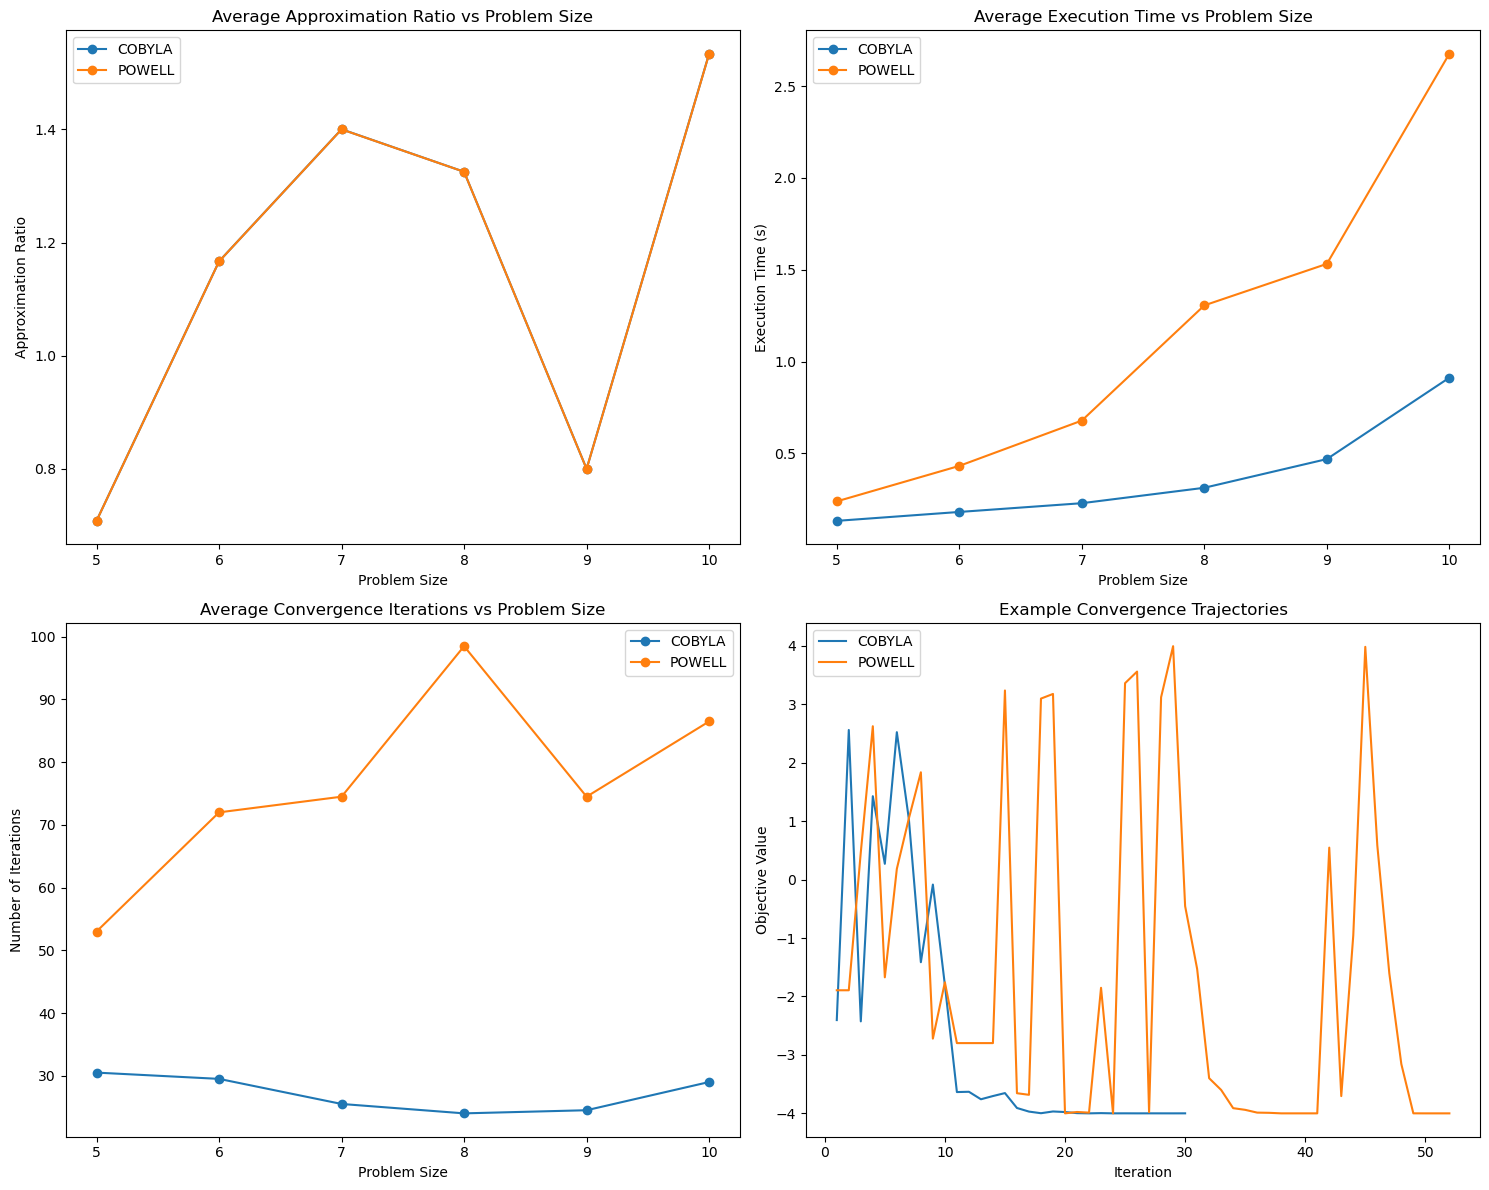

In [31]:
def benchmark_optimizers(
    min_size: int = 4,
    max_size: int = 6,
    trials: int = 5,
    reps: int = 1,
    shots: int = 1024,
    mixer_types: list[str] = ['X', 'XY'],
    optimizers: list[str] = ['COBYLA', 'POWELL', 'BOBYQA', 'NELDER_MEAD'],
    plot_results: bool = True
) -> dict:
    """
    Benchmark different optimizers.
    """
    results = {
        'problem_sizes': [],
        'mixer_types': [],
        'optimizers': [],
        'approximation_ratios': [],
        'optimal_values': [],
        'execution_times': [],
        'convergence_iterations': [],
        'optimization_histories': []
    }
    
    for n in tqdm(range(min_size, max_size + 1), desc="Problem sizes"):
        for trial in range(trials):
            # Generate random problem instance
            A = np.random.randint(0, 2, size=(n, n))
            
            # Get classical optimal solution (minimum value)
            classical_optimal = brute_force_set_balancing(A)
            
            for mixer_type in mixer_types:
                for optimizer_name in optimizers:
                    print(f"\nSize {n}, Trial {trial}, {mixer_type}, {optimizer_name}")
                    
                    try:
                        # Run optimization
                        counts, quantum_value, history = solve_optimization_with_optimizer(
                            A,
                            optimizer_name,
                            reps=reps,
                            shots=shots,
                            mixer_type=mixer_type
                        )
                        
                        # Calculate approximation ratio
                        # Since we're minimizing, and quantum_value should be >= classical_optimal,
                        # the ratio should be classical_optimal / quantum_value
                        # This ensures the ratio is between 0 and 1
                        approx_ratio = classical_optimal / abs(quantum_value)
                        
                        exec_time = history['time'][-1]
                        iterations = len(history['iterations'])
                        
                        # Store results
                        results['problem_sizes'].append(n)
                        results['mixer_types'].append(mixer_type)
                        results['optimizers'].append(optimizer_name)
                        results['approximation_ratios'].append(approx_ratio)
                        results['optimal_values'].append(quantum_value)
                        results['execution_times'].append(exec_time)
                        results['convergence_iterations'].append(iterations)
                        results['optimization_histories'].append(history)
                        
                        print(f"Classical optimal: {classical_optimal:.3f}")
                        print(f"Quantum value: {quantum_value:.3f}")
                        print(f"Approximation ratio: {approx_ratio:.3f}")
                        print(f"Iterations: {iterations}")
                        print(f"Time: {exec_time:.2f}s")
                        
                    except Exception as e:
                        print(f"Error with {optimizer_name}: {str(e)}")
                        print(f"Full error: {e.__class__.__name__}")
                        import traceback
                        traceback.print_exc()
    
    if plot_results:
        plot_benchmark_results(results)
    
    return results


def plot_benchmark_results(results: dict):
    """Plot benchmark results."""
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Get unique values
    sizes = sorted(set(results['problem_sizes']))
    optimizers = sorted(set(results['optimizers']))
    
    # Plot approximation ratios
    for opt in optimizers:
        ratios = [np.mean([r for r, o, s in zip(results['approximation_ratios'],
                                               results['optimizers'],
                                               results['problem_sizes'])
                          if o == opt and s == size])
                 for size in sizes]
        ax1.plot(sizes, ratios, marker='o', label=opt)
    
    ax1.set_xlabel('Problem Size')
    ax1.set_ylabel('Approximation Ratio')
    ax1.set_title('Average Approximation Ratio vs Problem Size')
    ax1.legend()
    
    # Plot execution times
    for opt in optimizers:
        times = [np.mean([t for t, o, s in zip(results['execution_times'],
                                              results['optimizers'],
                                              results['problem_sizes'])
                         if o == opt and s == size])
                for size in sizes]
        ax2.plot(sizes, times, marker='o', label=opt)
    
    ax2.set_xlabel('Problem Size')
    ax2.set_ylabel('Execution Time (s)')
    ax2.set_title('Average Execution Time vs Problem Size')
    ax2.legend()
    
    # Plot convergence iterations
    for opt in optimizers:
        iters = [np.mean([i for i, o, s in zip(results['convergence_iterations'],
                                              results['optimizers'],
                                              results['problem_sizes'])
                         if o == opt and s == size])
                for size in sizes]
        ax3.plot(sizes, iters, marker='o', label=opt)
    
    ax3.set_xlabel('Problem Size')
    ax3.set_ylabel('Number of Iterations')
    ax3.set_title('Average Convergence Iterations vs Problem Size')
    ax3.legend()
    
    # Plot example convergence trajectory
    for opt in optimizers:
        history = next(h for h, o in zip(results['optimization_histories'],
                                        results['optimizers'])
                      if o == opt)
        ax4.plot(history['iterations'], history['values'], label=opt)
    
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Objective Value')
    ax4.set_title('Example Convergence Trajectories')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Import all necessary Qiskit packages
    from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
    
    # Run benchmark with different optimizers
    results = benchmark_optimizers(
        min_size=5,
        max_size=10,
        trials=2,
        mixer_types=['X'],
        optimizers=['COBYLA', 'POWELL'],
        plot_results=True
    )

In [10]:
def benchmark_optimizers(
    min_size: int = 4,
    max_size: int = 6,
    trials: int = 5,
    reps: int = 1,
    shots: int = 1024,
    mixer_types: list[str] = ['X', 'XY'],
    optimizers: list[str] = ['COBYLA', 'POWELL', 'BOBYQA', 'NELDER_MEAD'],
    plot_results: bool = True
) -> dict:
    """
    Benchmark different optimizers.
    """
    results = {
        'problem_sizes': [],
        'mixer_types': [],
        'optimizers': [],
        'approximation_ratios': [],
        'optimal_values': [],
        'execution_times': [],
        'convergence_iterations': [],
        'optimization_histories': []
    }
    
    for n in tqdm(range(min_size, max_size + 1), desc="Problem sizes"):
        for trial in range(trials):
            # Generate random problem instance
            A = np.random.randint(0, 2, size=(n, n))
            
            # Get classical optimal solution using brute force
            classical_optimal = brute_force_set_balancing(A)
            
            for mixer_type in mixer_types:
                for optimizer_name in optimizers:
                    print(f"\nSize {n}, Trial {trial}, {mixer_type}, {optimizer_name}")
                    
                    try:
                        # Set up specific mixer parameters
                        ring = mixer_type == 'XY'
                        allowed_pairs = [(i, i+1) for i in range(n-1)] if mixer_type == 'SWAP' else None
                        
                        # Create the cost Hamiltonian
                        operator = create_cost_operator(A)
                        
                        # Create the parameterized ansatz circuit
                        ansatz = create_qaoa_ansatz(A, reps, mixer_type, ring, allowed_pairs)
                        
                        # Set up the optimizer
                        optimizer = get_optimizer(optimizer_name)
                        
                        # Create callback to track optimization history
                        optimization_history = {
                            'values': [],
                            'parameters': [],
                            'iterations': [],
                            'time': []
                        }
                        
                        start_time = time.time()
                        
                        def callback(eval_count, parameters, value, meta):
                            optimization_history['values'].append(value)
                            optimization_history['parameters'].append(parameters.copy())
                            optimization_history['iterations'].append(eval_count)
                            optimization_history['time'].append(time.time() - start_time)
                        
                        # Set up SamplingVQE
                        sampler = Sampler()
                        initial_point = np.random.random(2 * reps) * 2 * np.pi
                        
                        vqe = SamplingVQE(
                            sampler,
                            ansatz,
                            optimizer,
                            initial_point=initial_point,
                            callback=callback
                        )
                        
                        # Run the algorithm
                        result = vqe.compute_minimum_eigenvalue(operator)
                        
                        # Get counts and analyze results
                        counts = {format_bitstring(int(k), n): v 
                                for k, v in result.eigenstate.items()}
                        
                        # Get best solution from measurements
                        best_bitstring, quantum_value = analyze_results(counts, A)
                        
                        # Calculate approximation ratio (classical_optimal / quantum_value)
                        # Since both values are positive and we're minimizing,
                        # a better ratio is quantum_value / classical_optimal
                        # (closer to 1 means better approximation)
                        approx_ratio = classical_optimal / quantum_value
                        
                        exec_time = time.time() - start_time
                        iterations = len(optimization_history['iterations'])
                        
                        # Store results
                        results['problem_sizes'].append(n)
                        results['mixer_types'].append(mixer_type)
                        results['optimizers'].append(optimizer_name)
                        results['approximation_ratios'].append(approx_ratio)
                        results['optimal_values'].append(quantum_value)
                        results['execution_times'].append(exec_time)
                        results['convergence_iterations'].append(iterations)
                        results['optimization_histories'].append(optimization_history)
                        
                        print(f"Classical optimal: {classical_optimal:.3f}")
                        print(f"Quantum value: {quantum_value:.3f}")
                        print(f"Approximation ratio: {approx_ratio:.3f}")
                        print(f"Best bitstring: {best_bitstring}")
                        print(f"Iterations: {iterations}")
                        print(f"Time: {exec_time:.2f}s")
                        
                    except Exception as e:
                        print(f"Error with {optimizer_name}: {str(e)}")
                        print(f"Full error: {e.__class__.__name__}")
                        import traceback
                        traceback.print_exc()
    
    if plot_results:
        plot_benchmark_results(results)
    
    return results

if __name__ == "__main__":
    # Import all necessary Qiskit packages
    from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
    
    # Run benchmark with different optimizers
    results = benchmark_optimizers(
        min_size=13,
        max_size=14,
        trials=10,
        mixer_types=['X'],
        optimizers=['COBYLA', 'POWELL','NELDER_MEAD'],
        plot_results=True
    )

Problem sizes:   0%|                                      | 0/2 [00:00<?, ?it/s]


Size 13, Trial 0, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 0, X, POWELL


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 0, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Size 13, Trial 1, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 1, X, POWELL


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 1, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 2, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 2, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 2, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 3, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 3, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 3, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 4, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 4, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 4, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 5, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 5, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 5, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 6, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 6, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 6, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 7, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 7, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 7, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 8, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 8, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 8, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 9, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 9, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 13, Trial 9, X, NELDER_MEAD


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Problem sizes:  50%|███████████████               | 1/2 [00:02<00:02,  2.69s/it]

Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 0, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 0, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 0, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 1, X, COBYLA


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 1, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 1, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Size 14, Trial 2, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 2, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 2, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Size 14, Trial 3, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 3, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined

Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Full error: NameError

Size 14, Trial 3, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 4, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 4, X, POWELL


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 4, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 5, X, COBYLA


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 5, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 5, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 6, X, COBYLA


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 6, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 6, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Size 14, Trial 7, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 7, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 7, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 8, X, COBYLA


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined


Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 8, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 8, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined



Size 14, Trial 9, X, COBYLA
Error with COBYLA: name 'get_optimizer' is not defined
Full error: NameError

Size 14, Trial 9, X, POWELL
Error with POWELL: name 'get_optimizer' is not defined
Full error: NameError


Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Traceback (most recent call last):
  File "/var/folders/sy/v37gs57d4jjcj4xx28hgmt7h0000gn/T/ipykernel_44748/1398660899.py", line 49, in benchmark_optimizers
    optimizer = get_optimizer(optimizer_name)
NameError: name 'get_optimizer' is not defined
Problem sizes: 100%|██████████████████████████████| 2/2 [00:06<00:00,  3.19s/it]


Size 14, Trial 9, X, NELDER_MEAD
Error with NELDER_MEAD: name 'get_optimizer' is not defined
Full error: NameError


NameError: name 'plot_benchmark_results' is not defined